<center><font size=3><b>FINM 33150 Regression Analysis and Quant Trading Strategies</b></font></center>
<br>
<center><b><i><font size=2>HW3 Financial Ratio Quantile Strategies</font></i></b></center>
<br>
<center><font size=2>Zhiwei Hu</font></center>

### Section 0: to Load Libraries and Set-up the Environment

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import matplotlib.pyplot as plt
import math
plt.rcParams["figure.figsize"] = (16,9)
import seaborn as sns
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display
quandl.ApiConfig.api_key = 'LFxwzaCbdfby5FExQSRc'

### Section I: to load the data into DataFrame and filter qualified tickers
* **FC**:Fundamental Condensed - over 200 fundamental indicators for over 19500 companies.
* **FR**:Fundamental Ratios - 26 fundamental ratios for over 19500 companies.
* **MT**:Master Table - descriptive information about all tickers.
* **MKTV**:supplementary information to Zacks fundamentals, with updated values for market capitalization and enterprise value.
* **SHRS**:supplementary information to Zacks fundamentals, with updated values for common shares outstanding and average diluted shares outstanding. 
* **HDM**:historical daily corporate actions for over 7,000 U.S. and Canadian listed companies.

##### **First of all, we filter out all tickers:**
* Has per end date as early as 2013-12-31
* Not in the sector of automobil, finance nor insurance

In [323]:
# firstly to filter out some tickers
FC = quandl.get_table("ZACKS/FC",per_end_date='2013-12-31',
                      qopts={"columns":["m_ticker", "ticker","per_end_date","zacks_sector_code","zacks_x_ind_code"]},paginate=True)
FC = FC[(FC['zacks_sector_code']!=13) & (FC['zacks_sector_code']!=5)]
FC

,m_ticker,ticker,per_end_date,zacks_sector_code,zacks_x_ind_code
None,,,,,
0,CPG,3262Q,2013-12-31,14.0,194.0
1,CPG,3262Q,2013-12-31,14.0,194.0
6,AACA,AACAY,2013-12-31,10.0,50.0
7,AACA,AACAY,2013-12-31,10.0,50.0
8,ATAI,AACG,2013-12-31,2.0,172.0
...,...,...,...,...,...
13367,RXN2,ZWS,2013-12-31,7.0,97.0
13370,ZYNE,ZYNE,2013-12-31,4.0,107.0
13371,ZYNE,ZYNE,2013-12-31,4.0,107.0


##### This will give us more than 5000 avaliable tickers

In [324]:
ticker_list = list(FC.drop_duplicates(subset='ticker', keep="first")['ticker'])
len(ticker_list)

5828

##### Next, we apply the FR/TOT_DEBT_TOT_EQUITY criteria, to filter out those smaller than 0.1

In [325]:
FR = quandl.get_table("ZACKS/FR",per_end_date='2013-12-31',ticker=ticker_list,
                      qopts={"columns":["m_ticker", "ticker","per_end_date","tot_debt_tot_equity"]},paginate=True)
FR = FR[(FR['tot_debt_tot_equity']>0.1)]
FR = FR.drop_duplicates(subset='ticker', keep="first")
FR

,m_ticker,ticker,per_end_date,tot_debt_tot_equity
None,,,,
0,CPG,3262Q,2013-12-31,0.1838
2,AACA,AACAY,2013-12-31,0.1163
6,AAC3,AACH,2013-12-31,3.6249
12,AAOI,AAOI,2013-12-31,0.4139
16,AAP2,AAP,2013-12-31,0.6949
...,...,...,...,...
10309,ZTCO,ZTCOY,2013-12-31,1.1364
10311,ZOOM,ZTNO,2013-12-31,0.4144
10313,ZTS,ZTS,2013-12-31,3.8015


In [326]:
tick_list = list(FR['ticker'])

**Now, we furtherly check if the tickers we have selected so far all have EOD prices through January 2014 to January 2021 by qurying the QUOTEMEDIA/PRICES, if the returned values are not None, then it should be fine. We continue to do so until we found 200 avaliable tickers.**

In [327]:
# To define a ADJ_EOD_Price filter in an efficient way
def EOD_PX_FT(ticker_name):
    df_temp = quandl.get_table('QUOTEMEDIA/PRICES',ticker=ticker_name,date='2014-01-02,2021-01-04').set_index('date')
    return (df_temp.shape[0] == 2) & (df_temp.adj_close<5000).all() & (df_temp.adj_close>0).all() # to filter out some abnormal prices

In [328]:
import random
random.shuffle(tick_list)
qualified = []
for ticker in tick_list:
    result = EOD_PX_FT(ticker)
    if result == True:
        qualified.append(ticker)
    if len(qualified)<350:
        continue
    else:
        break

In [329]:
len(qualified)

350

##### So far, we have filtered out more than 200 tickers for further analysis. We now try to retrive and combining all data.

### Section II: To Select Financial Ratios
* Debt to Market Cap - Will simply use FR/TOT_DEBT_TOT_EQUITY indicator
* Return on Investment - Will refer to indicators such as FR/RET_INVST, MKTV/MKT_VAL, FC/NET_LTERM_DEBT, FC/TOT_LTERM_DEBT
* Price to Earnings - Will refer to FC/EPS_DILUTED_NET, BASIC_NET_EPS, SHRS/SHARES_OUT, MKT/MKT_VAL

In [331]:
# define the function of pulling needed EOD prices and financial ratios for each ticker
def eod_prices(ticker):
    data =  quandl.get_table('QUOTEMEDIA/PRICES',ticker=ticker,qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                          date={ 'gte': '2013-09-30', 'lte': '2021-01-01' }).set_index('date')[::-1]
    return data

def zacks_ratios(ticker):
    FC_ = quandl.get_table("ZACKS/FC",ticker = ticker,per_end_date={ 'gte': '2013-09-30', 'lte': '2020-12-31' },
                          qopts={"columns":[ "ticker","per_end_date","net_lterm_debt","tot_lterm_debt","eps_diluted_net","basic_net_eps","filing_date"]}
                              ,paginate=True).drop_duplicates(subset='per_end_date', keep="last").set_index("per_end_date")
    FR_ = quandl.get_table("ZACKS/FR",ticker = ticker,per_end_date={ 'gte': '2013-09-30', 'lte': '2020-12-31' },
                          qopts={"columns":[ "ticker","per_end_date","ret_invst","tot_debt_tot_equity"]}
                              ,paginate=True).drop_duplicates(subset='per_end_date', keep="last").set_index("per_end_date")
    MKTV_ = quandl.get_table("ZACKS/MKTV",ticker = ticker,per_end_date={ 'gte': '2013-09-30', 'lte': '2020-12-31' },
                          qopts={"columns":[ "ticker","per_end_date","mkt_val"]}
                              ,paginate=True).set_index("per_end_date")[::-1]
    SHRS_ = quandl.get_table("ZACKS/SHRS",ticker = ticker,per_end_date={ 'gte': '2013-09-30', 'lte': '2020-12-31' },
                          qopts={"columns":[ "ticker","per_end_date","shares_out"]}
                              ,paginate=True).set_index("per_end_date")[::-1]
    zacks_ = pd.concat([FC_,FR_,MKTV_,SHRS_],axis=1)
    zacks_ = zacks_.loc[:,~zacks_.columns.duplicated()]
    zacks_.set_index('filing_date',drop=True,inplace=True) # now we reset the index as the filing date as it's the actual date 
    zacks_.index.names = ['date']
    return zacks_

def data_merger(ticker):
    eod_data = eod_prices(ticker)
    zacks_data = zacks_ratios(ticker)
    merged_data = eod_data.merge(zacks_data,on="date",how='left')
    merged_data.drop(columns={"ticker_y"},inplace=True)
    return merged_data

##### Data Handling - to convert them into Daily Data
* Debt to Market Cap - Assume the total debt does not change between period reporting dates, only update the daily (Adjusted Close Price) * (Shares Outstanding) as the multiplier of FR/TOT_DEBT_TOT_EQUITY.
* Return on Investment - Assume the 'Returns' does not change between reporting periods, only update the denominator daily based on daily market values.
* Price to Earnings - Assume the 'Earnings' does not change between reporting periods, only update the prices daily to reflect the changes.

In [332]:
# Now we try to align the data
def data_align(df):
    data = df.copy()
    
    # Fill the nan value with previous entries
    data['shares_out'].fillna(method='ffill',inplace=True)
    data['tot_lterm_debt'].fillna(method='ffill',inplace=True)
    data['net_lterm_debt'].fillna(method='ffill',inplace=True)
    data['tot_debt_tot_equity'].fillna(method='ffill',inplace=True)
    data['ret_invst'].fillna(method='ffill',inplace=True)
    
    # The debt to market Cap calculation
    data['daily_mkt_val'] = np.where(data['mkt_val'].isnull(),data['adj_close']*data['shares_out'],data['mkt_val'])
    data['mkt_val'].fillna(method='ffill',inplace=True)
    data['mkt_val_chg'] = (data['daily_mkt_val']/data['mkt_val'])
    data['tot_debt_tot_equity'] = data['tot_debt_tot_equity']*(1/data['mkt_val_chg'])
    
    # The return on investment calculation
    # So the investment is also a slow variable that changes only on the report date
    data['Investment'] = data['mkt_val'] + np.where(data['net_lterm_debt'].isnull().any()==False,
                                                    data['net_lterm_debt'],data['tot_lterm_debt'])
    data['Investment_Daily'] = data['daily_mkt_val'] + np.where(data['net_lterm_debt'].isnull().any()==False,
                                                    data['net_lterm_debt'],data['tot_lterm_debt'])
    data['Investment_Chg'] = data['Investment_Daily']/data['Investment']
    data['ret_invst'] = data['ret_invst']*(1/data['Investment_Chg'])
    
    # The Price to Earnings calculation
    data['eps_diluted_net'].fillna(method='ffill',inplace=True)
    data['basic_net_eps'].fillna(method='ffill',inplace=True)
    data['PE'] = data['adj_close']/np.where(data['eps_diluted_net'].isnull().any()==False,
                                                    data['eps_diluted_net'],data['basic_net_eps'])
    
    data_ = data[['ticker_x','tot_debt_tot_equity','ret_invst','PE','adj_close']].loc['2013-12-31':]
    data_.rename(columns={'ticker_x':'ticker','tot_debt_tot_equity':'TDTE','ret_invst':'ROI','adj_close':'PX'},inplace=True)
    
    return data_

In [333]:
# Now we Fetch the data for each ticker
ticker_count = 0
ticker_dfs = {}
for ticker in qualified:
    try:
        data = data_merger(ticker)
        data = data_align(data)
        if data.shape[0] == 1764: # check again if the dataframes are of the same length
            ticker_dfs[ticker] = data
            ticker_count += 1
        if ticker_count%10 == 0:
            print('{0} tickers has been processed...'.format(ticker_count))
        if ticker_count == 300: # to make sure we will later have at least 200 feasible calculations
            break
    except:
        None
all_df = pd.concat(ticker_dfs.values(),axis=0)

10 tickers has been processed...
20 tickers has been processed...
30 tickers has been processed...
40 tickers has been processed...
50 tickers has been processed...
60 tickers has been processed...
70 tickers has been processed...
70 tickers has been processed...
80 tickers has been processed...
90 tickers has been processed...
100 tickers has been processed...
110 tickers has been processed...
120 tickers has been processed...
130 tickers has been processed...
140 tickers has been processed...
150 tickers has been processed...
160 tickers has been processed...
170 tickers has been processed...
180 tickers has been processed...
190 tickers has been processed...
190 tickers has been processed...
200 tickers has been processed...
210 tickers has been processed...
220 tickers has been processed...
230 tickers has been processed...
240 tickers has been processed...
250 tickers has been processed...
260 tickers has been processed...
270 tickers has been processed...
280 tickers has been pro

In [335]:
all_df.to_pickle('/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/all_df.pkl')

In [336]:
TDTE = pd.DataFrame()
ROI = pd.DataFrame()
PE = pd.DataFrame()
PX = pd.DataFrame()
for key, value in ticker_dfs.items():
    TDTE=pd.concat([TDTE,value['TDTE'].rename(key)],axis=1)
    ROI = pd.concat([ROI,value['ROI'].rename(key)],axis=1)
    PE = pd.concat([PE,value['PE'].rename(key)],axis=1)
    PX = pd.concat([PX,value['PX'].rename(key)],axis=1)
TDTE.to_pickle('/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/TDTE.pkl')
ROI.to_pickle('/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/ROI.pkl')
PE.to_pickle('/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/PE.pkl')
PX.to_pickle('/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/PX.pkl')

#### Now we re-load the data from pickle, to avoid retriving data from Quandl too frequently. The analysis conducted below will only use the fundamental factors we have filtered and retrived.

In [12]:
all_df = pd.read_pickle(r'/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/all_df.pkl')
TDTE = pd.read_pickle(r'/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/TDTE.pkl')
ROI = pd.read_pickle(r'/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/ROI.pkl')
PE = pd.read_pickle(r'/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/PE.pkl')
PX = pd.read_pickle(r'/Users/Zhiwei Hu/Desktop/Winter 2022/Regression_Analysis_and_Quant_Trading/PX.pkl')

In [13]:
for df in [TDTE,ROI,PE]:
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    df.dropna(axis=1,how='any',inplace=True)

### Section III: Quantile Trading Analysis
##### Basics about our Quantile Trading Stategy
* Here I built up a quantile trading strategy class.
* We will try **different fundamentals (ROI, TDTE, PE, or combinations) both in the actual value and in the percent change** to test our strategies.
* We will also try **different sampling periods (rebalancing our long-short list on weekly/month/quarterly)** to test our strategy.
* The threshold, both **the upper boundary and the lower boundary are by default set to be 0.95 and 0.05. They could be changed, however**.
* We're longing/shorting each ticker with only 1 size, and the max position during the whole trading time, after conducting several simulations, will be around 500. **So we simply set 5000 as our initial capital.**

In [22]:
# We need to import the 3M LIBOR data before further analysis
LIBOR = quandl.get('FRED/LIOR3M', start_date='2013-01-01', end_date='2021-01-01').mean()

In [78]:
from tabulate import tabulate
class quantile_ts:
    def __init__(self,resampled_df,PX,upper=0.95,lower=0.05):
        self.ratios_data = resampled_df 
        self.PX = PX
        self.low = {}
        self.high = {}
        self.long = {}
        self.short = {}
        self.rebalance_dates = list(resampled_df.index)
        self.all_tickers = resampled_df.columns
        self.strategy_long = []
        self.strategy_short = []
        self.all_trade_dates = PX.index
        self.balance = 5000 # The initial capital, we simply set it to 5000
        self.balance_dict = {}
        self.market_val_dict = {}
        self.upper = upper
        self.lower = lower
        self.df_result = None
        
    def quantile(self):
        for date in self.rebalance_dates:
            self.long[date] = []
            self.short[date] = []

        for i in range(self.ratios_data.shape[0]):
            self.low[self.rebalance_dates[i]] = np.quantile(self.ratios_data.iloc[i,:],self.lower)
            self.high[self.rebalance_dates[i]] = np.quantile(self.ratios_data.iloc[i,:],self.upper)
        low_ = pd.Series(data=self.low)
        high_ = pd.Series(data=self.high)
        self.ratios_data = pd.concat([self.ratios_data,low_.rename('Lower Bound'),high_.rename('Higher Bound')],axis=1)

        for date in self.rebalance_dates:
            for ticker in self.all_tickers:
                if self.ratios_data.loc[date,ticker] < self.ratios_data.loc[date,'Lower Bound']:
                    self.short[date].append(ticker)
                elif self.ratios_data.loc[date,ticker] > self.ratios_data.loc[date,'Higher Bound']:
                    self.long[date].append(ticker)
                else:
                    pass
                
    def trade(self,perf = True):
        self.quantile()
        # Then the next step is to execute the long-short strategy over time
        # So the whole strategy will update the long-short list for each rebalancing time
        for trade_date in self.all_trade_dates:
            if trade_date in self.rebalance_dates:
                curr_long = self.long[trade_date]
                for strat_l_ticker in self.strategy_long:
                    if strat_l_ticker not in curr_long:
                        self.balance += self.PX.loc[trade_date,strat_l_ticker] # this ticker is no longer long
                for curr_long_ticker in curr_long:
                    if curr_long_ticker not in self.strategy_long:
                        self.balance -= self.PX.loc[trade_date,curr_long_ticker] # this ticker is newly long
                self.strategy_long = curr_long
                #display(self.strategy_long)

                curr_short = self.short[trade_date]
                for strat_s_ticker in self.strategy_short:
                    if strat_s_ticker not in curr_short:
                        self.balance -= self.PX.loc[trade_date,strat_s_ticker] # this ticker is no longer short
                for curr_short_ticker in curr_short:
                    if curr_short_ticker not in self.strategy_short:
                        self.balance += self.PX.loc[trade_date,curr_short_ticker] # this ticker is newly short
                self.strategy_short = curr_short
                #display(self.strategy_short)
                self.balance_dict[trade_date] = self.balance

            # re-calculate the position value for each date    
            mkt_value = 0
            for sl in self.strategy_long:
                mkt_value += self.PX.loc[trade_date,sl]
            for ss in self.strategy_short:
                mkt_value -= self.PX.loc[trade_date,ss]
            self.market_val_dict[trade_date] = mkt_value

        # in the end of the trading day we wipe out all positions
        for l in curr_long:
            self.balance += self.PX.loc[self.all_trade_dates[-1],l]
        for s in curr_short:
            self.balance -= self.PX.loc[self.all_trade_dates[-1],s]
        self.balance_dict[self.all_trade_dates[-1]] = self.balance
        #market_val_dict[all_trade_dates[-1]] = 0

        df_position = pd.DataFrame(self.market_val_dict.items(),columns=['Date','Position_Value']).set_index('Date')
        df_balance = pd.DataFrame(self.balance_dict.items(),columns=['Date','Balance_Value']).set_index('Date')
        df_position = df_position.join(df_balance,how='outer')
        df_position['Balance_Value'].fillna(method='ffill',inplace=True)
        df_position['PnL'] = df_position['Balance_Value']-5000
        self.df_result = df_position
        if perf == True:
            self.performance()
        return df_position
    
    def performance(self):
        # This will calculate the performance statistics
        final_return = self.df_result['PnL'][-1]/self.balance
        std = self.df_result['Position_Value'].std()
        sharpe_ratio = final_return/std
        sortino_ratio = (final_return - LIBOR)/std
        table = [["PnL $",self.df_result['PnL'][-1]],["Returns %",final_return*100],
                 ["Sharpe Ratio %",sharpe_ratio*100],["Sortino Ratio %",sortino_ratio*100]]
        print(tabulate(table,tablefmt="psql"))

##### Using Total-Debt-to-Total-Equity as the indicator, rebalancing our portfolios on both monthly and quarterly basis

+-----------------+-------------+
| PnL $           | 670.698     |
| Returns %       |  11.8274    |
| Sharpe Ratio %  |   0.0349458 |
| Sortino Ratio % |  -0.118511  |
+-----------------+-------------+
+-----------------+-------------+
| PnL $           | 428.663     |
| Returns %       |   7.89629   |
| Sharpe Ratio %  |   0.0242498 |
| Sortino Ratio % |  -0.135252  |
+-----------------+-------------+


Text(0.5, 1.0, 'PnL Using Total-Debt-to-Equity Quantile by Rebalancing Quarterly')

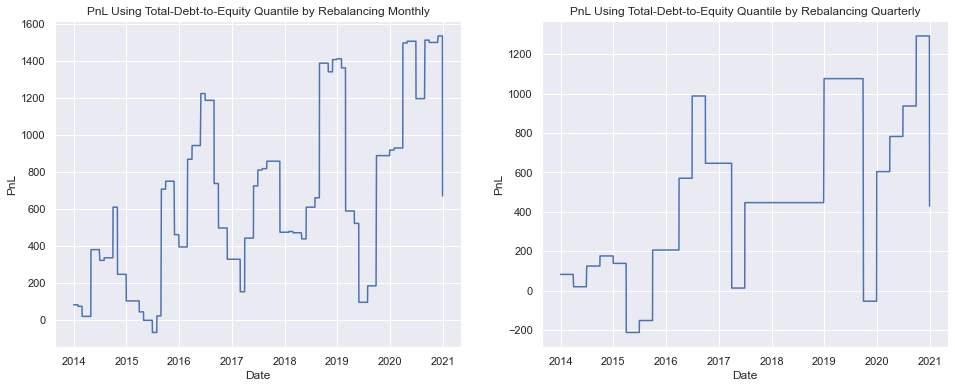

In [79]:
TDTE.index = pd.to_datetime(TDTE.index)

TDTE_m = TDTE.resample('M').mean() # monthly basis
Quantile_TS_1 = quantile_ts(TDTE_m,PX)
result = Quantile_TS_1.trade()

TDTE_q = TDTE.resample('Q').mean() # quarterly basis
Quantile_TS_2 = quantile_ts(TDTE_q,PX)
result_2 = Quantile_TS_2.trade()

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.lineplot(data = result.PnL,ax=ax[0]).set_title('PnL Using Total-Debt-to-Equity Quantile by Rebalancing Monthly')
sns.lineplot(data = result_2.PnL,ax=ax[1]).set_title('PnL Using Total-Debt-to-Equity Quantile by Rebalancing Quarterly')


* An observation we could have is here, that by increasing the frequency of rebalancing our portfolio from quarterly to monthly, the PnL also increases. **Using the Total-Debt-to-Equity as our fundamental, the best PnL we could have is by monthly adjusting our portfolios, with equal trading size for each ticker in our long-short list**, the PnL we finally got is around $700.
* The returns are relatively small since we set our initial capital as 10 times of the max position we would take during the whole trading simulations. Also the sharpe ratio is small, this is due to large fluctions in the value of our position value - in our strategy, we long-short tickers every month and since the trading size for every ticker is 1, by longing/shorting them, we mean longing/shorting them completely. So presumably there's relatively large volatilities in our position holdings.

##### Using ROI as the indicator, rebalancing our portfolios on both monthly and quarterly basis

+-----------------+--------------+
| PnL $           | 1650.78      |
| Returns %       |   24.8209    |
| Sharpe Ratio %  |    0.0474212 |
| Sortino Ratio % |   -0.0518074 |
+-----------------+--------------+
+-----------------+-------------+
| PnL $           | 764.939     |
| Returns %       |  13.2688    |
| Sharpe Ratio %  |   0.0230365 |
| Sortino Ratio % |  -0.0671343 |
+-----------------+-------------+


Text(0.5, 1.0, 'PnL Using Return on Investment Quantile by Rebalancing Monthly')

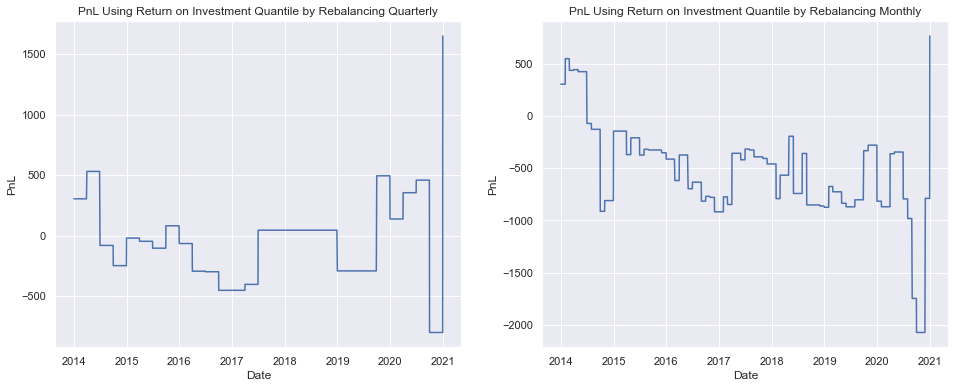

In [64]:
ROI.index = pd.to_datetime(ROI.index)

ROI_q = ROI.resample('Q').mean()
Quantile_TS_3 = quantile_ts(ROI_q,PX)
result_3 = Quantile_TS_3.trade()

ROI_m = ROI.resample('M').mean()
Quantile_TS_4 = quantile_ts(ROI_m,PX)
result_4 = Quantile_TS_4.trade()

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.lineplot(data = result_3.PnL,ax=ax[0]).set_title('PnL Using Return on Investment Quantile by Rebalancing Quarterly')
sns.lineplot(data = result_4.PnL,ax=ax[1]).set_title('PnL Using Return on Investment Quantile by Rebalancing Monthly')

However, by using the **Return on Investments** as our fundamental, the increase in rebalancing frequencies does not necessarily increase the final PnL. Rather, rebalancing our portfolio by quarterly gives us more promising results.

##### Using PE as the indicator, rebalancing our portfolios on both monthly and quarterly basis

+-----------------+------------+
| PnL $           | 365.673    |
| Returns %       |   6.81504  |
| Sharpe Ratio %  |   0.040465 |
| Sortino Ratio % |  -0.267919 |
+-----------------+------------+
+-----------------+-------------+
| PnL $           | 579.708     |
| Returns %       |  10.3896    |
| Sharpe Ratio %  |   0.0446763 |
| Sortino Ratio % |  -0.17866   |
+-----------------+-------------+


Text(0.5, 1.0, 'PnL Using PE Quantile by Rebalancing Monthly')

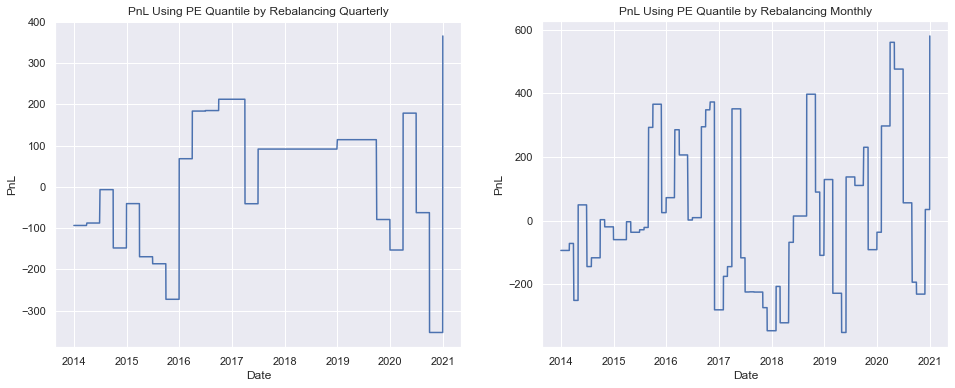

In [66]:
PE.index = pd.to_datetime(PE.index)

PE_q = PE.resample('Q').mean()
Quantile_TS_5 = quantile_ts(PE_q,PX)
result_5 = Quantile_TS_5.trade()

PE_m = PE.resample('M').mean()
Quantile_TS_6 = quantile_ts(PE_m,PX)
result_6 = Quantile_TS_6.trade()

fig, ax = plt.subplots(1,2,figsize=(16,6))
sns.lineplot(data = result_5.PnL,ax=ax[0]).set_title('PnL Using PE Quantile by Rebalancing Quarterly')
sns.lineplot(data = result_6.PnL,ax=ax[1]).set_title('PnL Using PE Quantile by Rebalancing Monthly')

Again, in regard to the Price-to-Earnings fundamental, the increase in rebalancing frequencies does give us higher PnL in the end. **Using PE ratios and update our long-short list on a monthly basis, with equal size position for each ticker**, we could obtain close to $600 PnL in the end.

##### Using both PE and Total-Debt-to-Equity as the indicator, rebalancing our portfolios on monthly basis

Text(0.5, 1.0, 'PnL Using Combined Factor Quantile by Rebalancing Monthly')

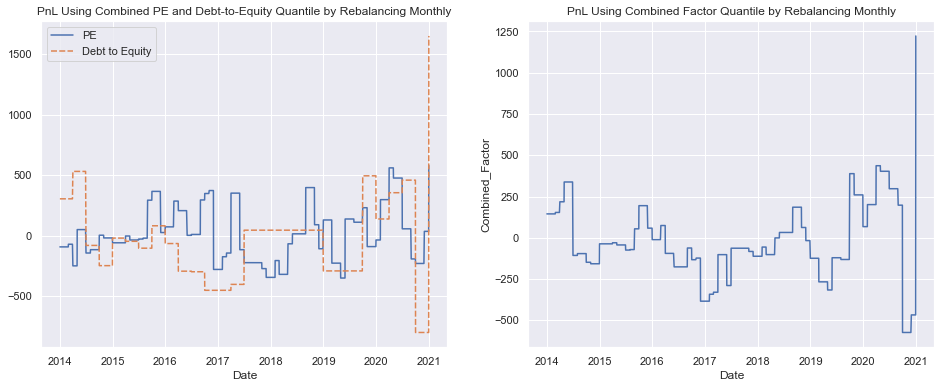

In [67]:
# Plot them together
fig, ax = plt.subplots(1,2,figsize=(16,6))

combined_df = pd.concat([result_6['PnL'].rename('PE'),result_3['PnL'].rename('Debt to Equity')],axis=1)
sns.lineplot(data = combined_df,ax=ax[0]).set_title('PnL Using Combined PE and Debt-to-Equity Quantile by Rebalancing Monthly')

# We now, for example, assign the weight for each factor, for example, 60% for Debt-to-Equity factor, and 40% for the PE factor.
combined_df['Combined_Factor'] = 0.6*combined_df['Debt to Equity'] + 0.4*combined_df['PE']
sns.lineplot(data = combined_df['Combined_Factor'],ax=ax[1]).set_title('PnL Using Combined Factor Quantile by Rebalancing Monthly')

##### By combining two fundamental factors, it indeed smooths out the fluctiuations during the whole holding period, and also gives us more PnL in the end.

### Section IV: Further Analysis
* In this section, we will further analyze two scenarios:
 - We use the **percentage change in each fundamental indicator** to decide the quantiles.
 - We try to apply **different thresholds.**

In [80]:
# Re-process of the data
TDTE_pct = TDTE.pct_change().dropna()
ROI_pct = ROI.pct_change().dropna()
PE_pct = PE.pct_change().dropna()

# define a function
def simulate(df,PX):
    df_m = df.resample('M').mean() # monthly basis
    df_q = df.resample('Q').mean() # quarterly basis
    df.index = pd.to_datetime(df.index)
    Quantile_TS_1 = quantile_ts(df_m,PX)
    Quantile_TS_2 = quantile_ts(df_q,PX)
    
    result = Quantile_TS_1.trade(False)
    result_2 = Quantile_TS_2.trade(False)
    return result, result_2

Text(0.5, 1.0, 'PnL Using Percentage Price-to-Earnings Quantile by Rebalancing Quarterly')

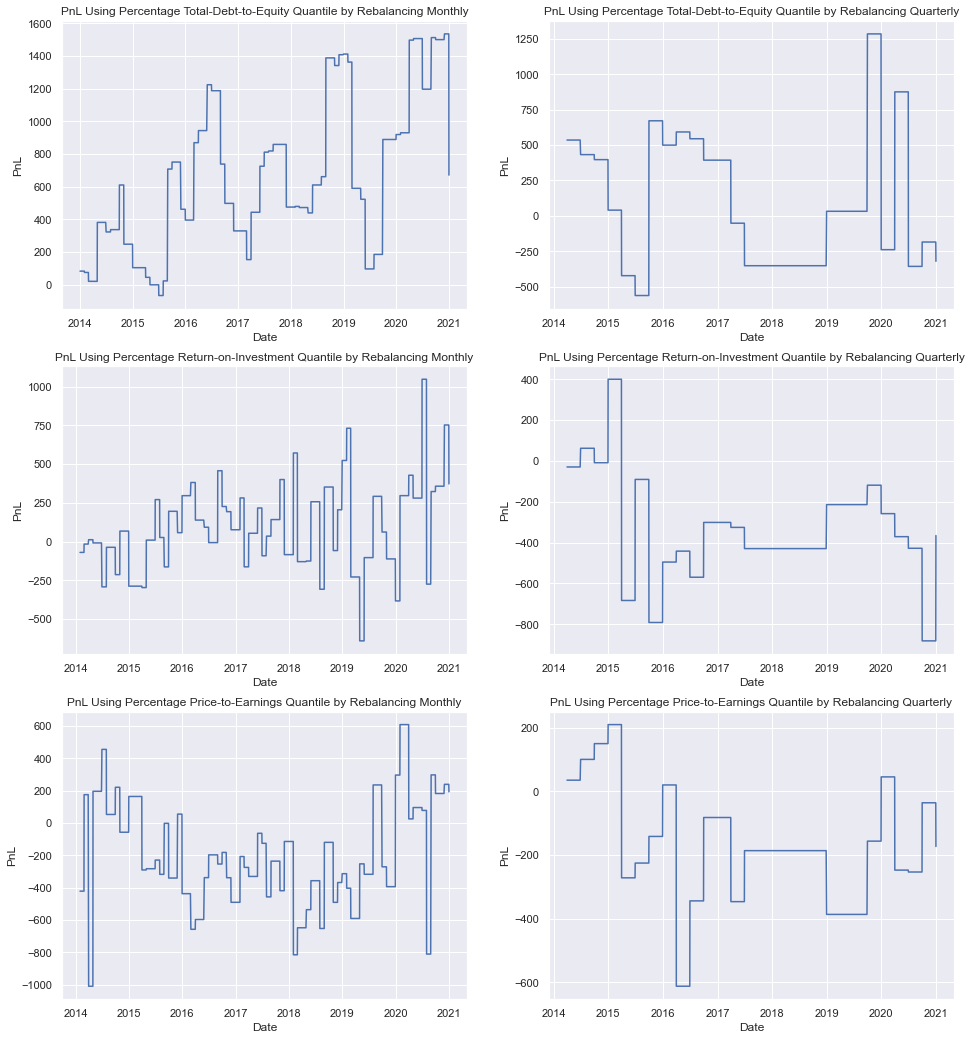

In [82]:
result_1, result_2 = simulate(TDTE_pct,PX)
result_3, result_4 = simulate(ROI_pct,PX)
result_5, result_6 = simulate(PE_pct,PX)

fig, ax = plt.subplots(3,2,figsize=(16,18))
sns.lineplot(data = result.PnL,ax=ax[0,0]).set_title('PnL Using Percentage Total-Debt-to-Equity Quantile by Rebalancing Monthly')
sns.lineplot(data = result_2.PnL,ax=ax[0,1]).set_title('PnL Using Percentage Total-Debt-to-Equity Quantile by Rebalancing Quarterly')

sns.lineplot(data = result_3.PnL,ax=ax[1,0]).set_title('PnL Using Percentage Return-on-Investment Quantile by Rebalancing Monthly')
sns.lineplot(data = result_4.PnL,ax=ax[1,1]).set_title('PnL Using Percentage Return-on-Investment Quantile by Rebalancing Quarterly')

sns.lineplot(data = result_5.PnL,ax=ax[2,0]).set_title('PnL Using Percentage Price-to-Earnings Quantile by Rebalancing Monthly')
sns.lineplot(data = result_6.PnL,ax=ax[2,1]).set_title('PnL Using Percentage Price-to-Earnings Quantile by Rebalancing Quarterly')

The graphs above shows the results **using percentage change in fundamental ratios in repace of the actual values.** However, using the percentage change does not guarantee higher PnL in the end, or rather, in most cases, it even yields negative PnL. A possible explanation could be: **higher, positive change in fundamental indicators changes doesn't mean stronger financial conditions.** For example, a higher percentage change in fundamental indicator could also be biased by a low base number.

From our previous analysis, the ROI seems to be the strongest indicator among all we have and gives the best PnL if we rebalance our strategy on a quarterly basis. So in the next step, we will use ROI as a sole indicator to test scenarios under different set of quantile thresholds.

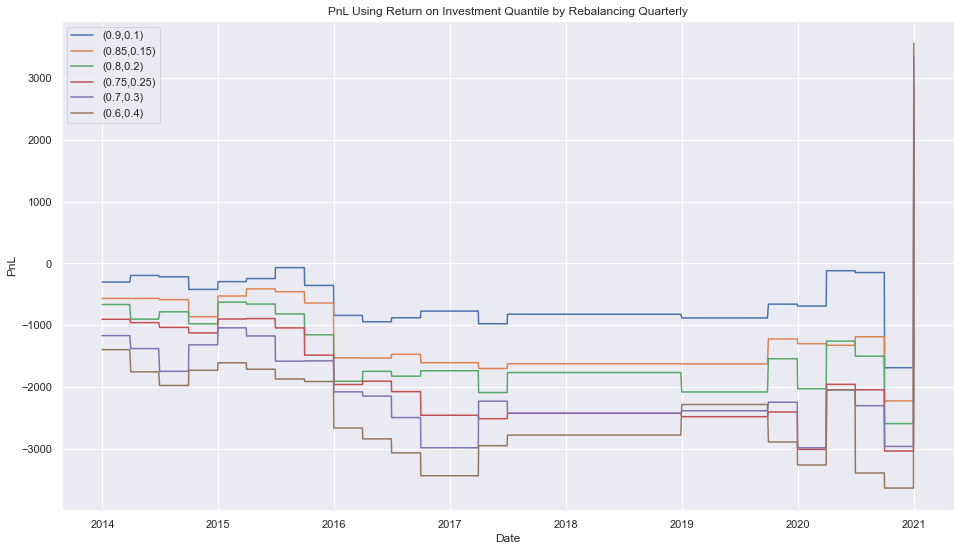

In [87]:
threshold_sets = [(0.9,0.1),(0.85,0.15),(0.8,0.2),(0.75,0.25),(0.7,0.3),(0.6,0.4)]

ROI.index = pd.to_datetime(ROI.index)
ROI_q = ROI.resample('Q').mean()

for sets in threshold_sets:
    Quantile_TS = quantile_ts(ROI_q,PX,sets[0],sets[1])
    result = Quantile_TS.trade(False)
    sns.lineplot(data = result.PnL).set_title('PnL Using Return on Investment Quantile by Rebalancing Quarterly')
plt.legend(labels=['(0.9,0.1)','(0.85,0.15)','(0.8,0.2)','(0.75,0.25)','(0.7,0.3)','(0.6,0.4)'])

Even though at the end of the simulation, after closing out all our long-short positions(the set of upper_threshold=0.6, lower_threshold=0.4 will have the highest PnL in the end, **I guess this is due to allowing more tickers trade on our book, however this won't be the case when we fully use our capital each time**), different combinations of quantile thresholds gives similar PnL, the more strict select of thresholds will perform more stable during the whole simulation period.

##### end of HW3